## imports

In [322]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import tensorflow as tf
import umap.umap_ as umap
from keras.layers import Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from sklearn.manifold import TSNE
from tensorflow import keras
from tensorflow.keras import layers

input_spe = (32, 32, 1)
latent_dim = 14

## Dataset

In [323]:
images = np.load('D:/magist/semestr 2/UczNienadwz/UNN/datasets/n0_b0_r0_s0/dataset_n0_b0_r0_s0.npy')
print(images.shape)
x_data, _ = images[:, 0, :, :], images[:, 1, :, :]
print(x_data.shape)

(36480, 2, 32, 32)
(36480, 32, 32)


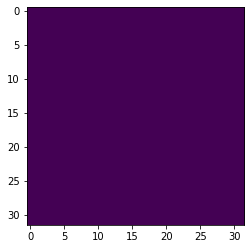

(8530, 32, 32)

In [324]:
plt.imshow(x_data[13])
plt.show()
space = x_data[13]
lst = []
for i in x_data:
    if np.array_equal(space, i):
        pass
    else:
        lst.append(i)

better_x_test = np.asarray(lst)
better_x_test.shape

In [325]:
x_data = better_x_test
print(x_data.shape)
x_data = np.expand_dims(x_data, -1).astype("float32") / 255
print(x_data.shape)
X_train = x_data

(8530, 32, 32)
(8530, 32, 32, 1)


## Encoder + Decoder = VAE

In [326]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mean, log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape = tf.shape(mean), mean = 0., stddev = 1.)
        return mean + tf.exp(log_var / 2) * epsilon


##### encoder

In [327]:
encoder_inputs = keras.Input(shape = input_spe)

x = Conv2D(32, 3, activation = "relu", strides = 2, padding = "same")(encoder_inputs)
x = Conv2D(64, 3, activation = "relu", strides = 2, padding = "same")(x)
x = Conv2D(64, 3, activation = "relu", strides = 2, padding = "same")(x)

x = Flatten()(x)
x = Dense(500, activation = "relu")(x)
z_mean = Dense(latent_dim, name = "z_mean")(x)
z_log_var = Dense(latent_dim, name = "z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name = "encoder")
# encoder.summary()
# plot_model(encoder, show_shapes = True, dpi = 80)

##### decoder

In [328]:
latent_inputs = keras.Input(shape = (latent_dim,))

x = Dense(4 * 4 * 64, activation = "relu")(latent_inputs)
x = Reshape((4, 4, 64))(x)

x = Conv2DTranspose(64, 3, activation = "relu", strides = 2, padding = "same")(x)
x = Conv2DTranspose(64, 3, activation = "relu", strides = 2, padding = "same")(x)
x = Conv2DTranspose(32, 3, activation = "relu", strides = 2, padding = "same")(x)
decoder_outputs = Conv2DTranspose(1, 3, activation = "sigmoid", padding = "same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name = "decoder")
# plot_model(decoder, show_shapes = True, dpi = 80)

##### vae

In [329]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name = "total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name = "reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name = "kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker, ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis = (1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(), "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(), }

## Fitting model

Epoch 1/20
267/267 [==============================] - 19s 58ms/step - loss: 382.6435 - reconstruction_loss: 292.2194 - kl_loss: 5.4545
Epoch 2/20
267/267 [==============================] - 11s 41ms/step - loss: 205.6240 - reconstruction_loss: 164.2086 - kl_loss: 17.0395
Epoch 3/20
267/267 [==============================] - 10s 39ms/step - loss: 141.5826 - reconstruction_loss: 112.5906 - kl_loss: 23.5748
Epoch 4/20
267/267 [==============================] - 15s 58ms/step - loss: 125.5696 - reconstruction_loss: 98.2987 - kl_loss: 25.2785
Epoch 5/20
267/267 [==============================] - 11s 40ms/step - loss: 118.3347 - reconstruction_loss: 92.0955 - kl_loss: 26.0314
Epoch 6/20
267/267 [==============================] - 11s 41ms/step - loss: 114.2940 - reconstruction_loss: 87.5938 - kl_loss: 26.5082
Epoch 7/20
267/267 [==============================] - 11s 43ms/step - loss: 112.2503 - reconstruction_loss: 84.6589 - kl_loss: 26.9222
Epoch 8/20
267/267 [==============================] -

Text(0.5, 0, 'Epoch')

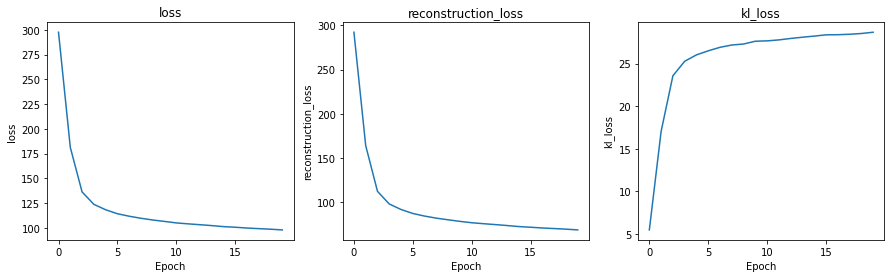

In [330]:
epochs = 20
batch_size = 32

vae = VAE(encoder, decoder)
vae.compile(optimizer = keras.optimizers.Adam())
history = vae.fit(X_train, epochs = epochs, batch_size = batch_size)
# history = vae.fit(X_train, X_train, epochs = 20, batch_size = 126, test={x_text, x_test} )

history.history.keys()

plt.figure(figsize = (15, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.subplot(1, 3, 2)
plt.plot(history.history['reconstruction_loss'])
plt.title('reconstruction_loss')
plt.ylabel('reconstruction_loss')
plt.xlabel('Epoch')
plt.subplot(1, 3, 3)
plt.plot(history.history['kl_loss'])
plt.title('kl_loss')
plt.ylabel('kl_loss')
plt.xlabel('Epoch')

# Test

In [349]:
# m, v, embeddings = vae.encoder.predict(x_data[np.random.choice(range(len(x_data)), 4000)], verbose = 0)
m, v, embeddings = vae.encoder.predict(x_data, verbose = 0)
print("embeddings", embeddings.shape)

embeddings (8530, 14)


### UMAP

##### for 2D

clusterable_embedding (8530, 2)


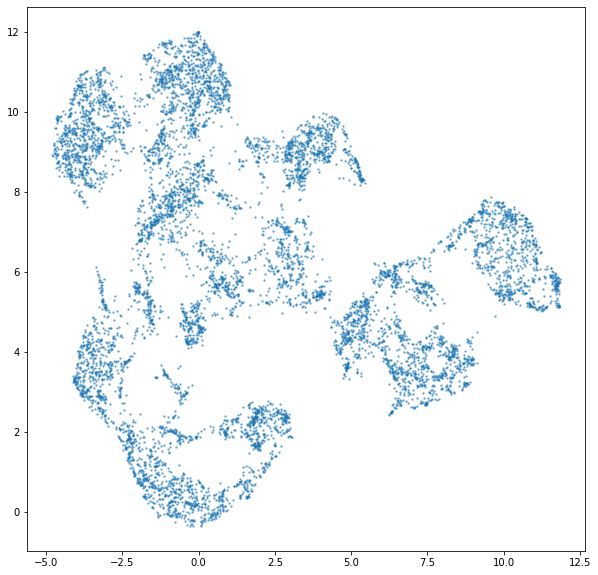

In [350]:
clusterable_embedding = umap.UMAP(n_neighbors = 10,
                                  min_dist = 0.1,
                                  n_components = 2,
                                  n_epochs = 300,
                                  metric='correlation')\
    .fit_transform(embeddings)

print("clusterable_embedding", clusterable_embedding.shape)
plt.figure(figsize=(10, 10))
plt.scatter(clusterable_embedding[:, 0] , clusterable_embedding[:, 1], alpha=0.5, s=2)
plt.show()

##### for 3D

In [351]:
# clusterable_embedding = umap.UMAP(n_neighbors = 10, min_dist = 0.1, n_components = 3, n_epochs = 300, metric = 'correlation').fit_transform(embeddings)
#
# print("clusterable_embedding", clusterable_embedding.shape)
#
# df = pd.DataFrame(clusterable_embedding, columns = ['x', 'y', 'z'])
# fig = px.scatter_3d(df, x = 'x', y = 'y', z = 'z', width = 800, height = 800)
# fig.update_traces(marker = dict(size = 1))
# fig.show()

### TSNE

##### for 2D

In [352]:
# tsne = TSNE(n_components=2, init='pca')
# X_tsne = tsne.fit_transform(embeddings)
#
# plt.figure(figsize=(10, 10))
# plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], alpha=0.5, s=2)
# plt.show()

##### for 3D

In [354]:
# tsne = TSNE(n_components = 3, init = 'pca')
# X_tsne = tsne.fit_transform(embeddings)
#
# df = pd.DataFrame(X_tsne, columns = ['x', 'y', 'z'])
# fig = px.scatter_3d(df, x = 'x', y = 'y', z = 'z', width = 800, height = 800)
# fig.update_traces(marker = dict(size = 1))
# fig.show()

### KMeans

#### looking for the number of clusters

In [363]:
min_value = 5
max_value = 60

from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(min_value, max_value)
for k in K:
    km = KMeans(init = 'k-means++', n_clusters = k, n_init = 10)
    km.fit(clusterable_embedding)
    Sum_of_squared_distances.append(km.inertia_)


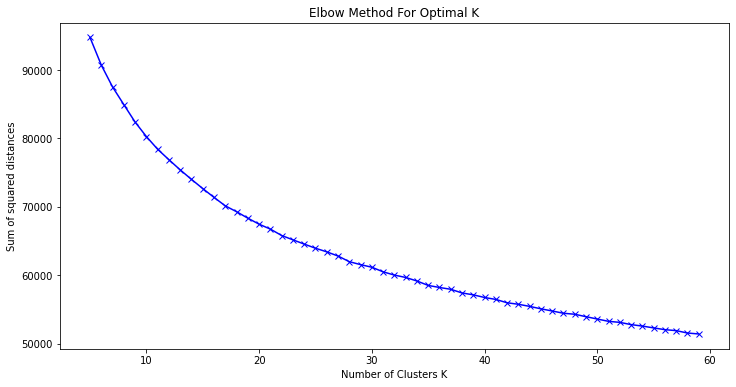

In [364]:

plt.figure(figsize = (12, 6))
plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.vlines(ymin=0, ymax=150000, x=8, colors='red')
# plt.text(x=8.2, y=130000, s="optimal K=8")
plt.xlabel('Number of Clusters K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal K')
plt.show()

#### enter the best number of clusters

In [365]:
best_num_clusters = 22

##### for 2D

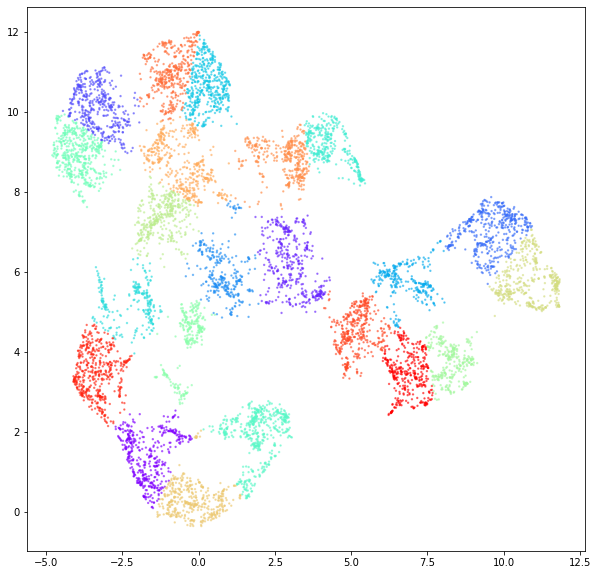

In [366]:
kmeans = KMeans(init='k-means++', n_clusters=best_num_clusters, n_init=50)
P = kmeans.fit_predict(clusterable_embedding)

plt.figure(figsize=(10, 10))
plt.scatter(clusterable_embedding[:, 0] , clusterable_embedding[:, 1], c=P, marker="o", picker=True, cmap="rainbow", alpha=0.5, s=2)
plt.show()

##### for 3D

In [359]:
# kmeans = KMeans(init = 'k-means++', n_clusters = best_num_clusters, n_init = 50)
# kmeans.fit(clusterable_embedding)
# P = kmeans.predict(clusterable_embedding)
#
# df = pd.DataFrame(clusterable_embedding, columns = ['x', 'y', 'z'])
# fig = px.scatter_3d(df, x = 'x', y = 'y', z = 'z', color = P, color_continuous_scale = "jet", width = 800, height = 800)
# fig.update_traces(marker = dict(size = 1))
# fig.show()